# PeDistance Linear Regression

### Initial settings

#### Dependencies

In [1]:
# YOLOv5 install dependencies
%pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt 

Note: you may need to restart the kernel to use updated packages.


In [2]:
#imutils
%pip install imutils

Note: you may need to restart the kernel to use updated packages.


#### Imports and Utilities

In [18]:
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import base64
from PIL import Image
import cv2
from pathlib import Path
from __future__ import print_function
import imutils
from imutils.object_detection import non_max_suppression
from imutils import paths
import argparse
import matplotlib.image as mpimg
import io

In [19]:
# Used as file name where saving model state
model_file_name="reg_state.pth"

# Get device based on available hardware
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# Convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.tensor(df.to_numpy()).float().to(device)

### Import Dataset

In [20]:
# Filtered fields read from dataset csv file
fields = [
    'Distance',
    'PedTopRightX', 
    'PedTopRightY',
    'PedBottomLeftX', 
    'PedBottomLeftY',
    'B64File'
]

df = pd.read_csv (r'./Dataset.csv', usecols=fields)
print(df.shape)

(6, 6)


### Normalize input feature 

In [42]:
def get_image_resolution(b64string):
    image = base64.b64decode(b64string)
    image = io.BytesIO(image)
    image = mpimg.imread(image, format='JPG')
    return image.shape
    
testone = df['B64File'][0]    
get_image_resolution(testone)

(1080, 1920, 3)

### Splitting dataset


In [22]:
# sklearn function to split pandas dataframe into train and test set
train, test = train_test_split(df, test_size = 0.3)
train = shuffle(train)

In [23]:
# parsing dataframes to pytorch tensor
Y_training = df_to_tensor(train.Distance)
Y_testing = df_to_tensor(test.Distance)

print(Y_training.shape)
print(Y_testing.shape)

torch.Size([4])
torch.Size([2])


#### Getting width  height from raw 2D screen points

In [43]:
def get_resized_box_dim(el):
    width = abs(el.PedTopRightX - el.PedBottomLeftX)
    height = abs(el.PedTopRightY - el.PedBottomLeftY)
    res = get_image_resolution(el.B64File)
    width = int((width * 640) / res[1])
    height = int((height * 360) / res[0])
    return width, height

In [44]:
X_training = df_to_tensor(train.apply(lambda el :  pd.Series(get_resized_box_dim(el), index=['width', 'height']), axis=1))
X_testing = df_to_tensor(test.apply(lambda el :  pd.Series(get_resized_box_dim(el), index=['width', 'height']), axis=1))

print(X_training.shape)
print(X_testing.shape)

torch.Size([4, 2])
torch.Size([2, 2])


### Linear Regression Module

In [30]:
class LinearRegressor(nn.Module):
    def __init__(self, in_size, out_size):
        super(LinearRegressor, self).__init__()
        self.criterion = nn.MSELoss()
        self.linear = nn.Linear(in_size,out_size)       
        
    # used to train linear regressor
    def fit(self, X_training, Y_training, X_testing, Y_testing, lr= 0.001, epochs=20000, momentum=0.0, reset_parameters= False):
        self.reset_parameters(reset_parameters)
        
        self.mean = X_training.mean(0)
        self.stds = X_training.std(0)
        X_training_norm = self._data_normalization(X_training)
        X_testing_norm = self._data_normalization(X_testing)
                
        self.optimizer = torch.optim.SGD(reg.parameters(), lr=lr, momentum=momentum)
        self.writer = SummaryWriter('logs/linear_regressor_lr' + str(lr) + '_momentum' + str(momentum) + '_epochs' + str(epochs))
        
        self._training(X_training_norm, Y_training, X_testing_norm, Y_testing, lr, epochs, momentum)
       
    def _training(self, X_training_norm, Y_training, X_testing_norm, Y_testing, l, epochs, momentum):
       
        for e in range(epochs):   
            reg.train()
            preds_train = self.forward(X_training_norm)
            l = self.criterion(preds_train.view(-1),Y_training)

            self.writer.add_scalar('loss/train', l.item(), global_step=e)

            l.backward()

            self.optimizer.step()    
            self.optimizer.zero_grad()
            
            reg.eval()
            with torch.set_grad_enabled(False):
                preds_test = self.forward(X_testing_norm)
                l = self.criterion(preds_test.view(-1),Y_testing)
                self.writer.add_scalar('loss/test', l.item(), global_step=e)    
        
    # used to get prediction based on trained linear regressor
    def predict(self, X):  
        X_norm = self._data_normalization(X)
        return self.linear(X_norm)
       
    # used to get final score tensor and predicted tensor based on train or test features and labels
    def score(self, X, Y):
        Y_preds = self.predict(X)
        l = self.criterion(Y_preds.view(-1),Y)
        return l, Y_preds
    
    # used to reset parameters before training
    def reset_parameters(self, reset_parameters= False):
        if reset_parameters:
            for layer in self.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
    
    # used to load parameters and model state to make predictions or continue training
    def load_state(self, path):
        if Path(path).exists():
            checkpoint = torch.load(path, map_location=get_device())
            self.mean = checkpoint["mean"]
            self.stds = checkpoint["stds"]
            self.load_state_dict(checkpoint["model_state_dict"])
    
    # used to save trained model state
    def save_state(self, path):
         torch.save({
            'mean': self.mean,
            'stds': self.stds,
            'model_state_dict': self.state_dict(),
            }, path)
        
    def _data_normalization(self, data):
        return (data-self.mean)/self.stds        
    
    def forward(self,x):
        result = self.linear(x)
        return result    

### Modular Linear Regression

In [31]:
reg = LinearRegressor(2,1).to(get_device())

In [32]:
reg.load_state(model_file_name)

In [34]:
reg.fit(X_training, Y_training, X_testing, Y_testing, reset_parameters=True)
reg.save_state(model_file_name)

In [55]:
%load_ext tensorboard
%tensorboard --logdir logs --host localhost

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 7588), started 0:06:40 ago. (Use '!kill 7588' to kill it.)

In [56]:
loss_train, Y_train_preds = reg.score(X_training, Y_training)
print("Loss train: " + str(loss_train.item()))
for p,c in zip(Y_training, Y_train_preds):
      print([p.item(), c.item()])

Loss train: 5.723167896270752
[10.666115760803223, 12.333844184875488]
[15.839526176452637, 15.586626052856445]
[20.021013259887695, 16.6948184967041]
[21.678512573242188, 16.71312713623047]
[7.54301643371582, 9.262710571289062]
[13.911056518554688, 14.67695426940918]
[18.37040901184082, 16.276599884033203]
[8.51720142364502, 10.915846824645996]
[14.126237869262695, 14.913525581359863]
[12.42719554901123, 13.406855583190918]
[13.54506778717041, 14.62346363067627]
[5.160181522369385, 1.5405406951904297]
[13.960257530212402, 14.858601570129395]
[17.626649856567383, 15.296563148498535]
[5.842499732971191, 8.859930992126465]
[7.4724440574646, 9.189477920532227]
[20.043264389038086, 15.6964750289917]
[21.745351791381836, -11.759552001953125]
[6.720939636230469, 7.588397979736328]
[14.815531730651855, 15.150097846984863]
[11.50833797454834, 13.623685836791992]
[12.497735977172852, 13.73353385925293]
[17.532909393310547, 15.986536979675293]
[16.202091217041016, 15.278255462646484]
[9.64525794

In [57]:
loss_testing, Y_testing_preds = reg.score(X_testing, Y_testing)
print("Loss testing: " + str(loss_testing.item()))
for p,c in zip(Y_testing, Y_testing_preds):
    print([p.item(), c.item()])

Loss testing: 36.40191650390625
[9.173828125, 11.370682716369629]
[6.968830585479736, 7.881329536437988]
[14.961503028869629, 13.6068115234375]
[7.017464637756348, 7.099814414978027]
[19.2500057220459, 16.223108291625977]
[9.42350959777832, 12.11414623260498]
[6.13748025894165, 5.065075874328613]
[12.561664581298828, 13.3702392578125]
[15.644881248474121, 15.53170108795166]
[17.899812698364258, 15.823198318481445]
[8.96793270111084, 11.279141426086426]
[5.629493236541748, 4.918610095977783]
[5.968113899230957, 4.3751020431518555]
[10.610386848449707, 12.080398559570312]
[11.459383010864258, 13.350496292114258]
[15.939093589782715, 15.550008773803711]
[5.891385078430176, 6.225325107574463]
[18.241552352905273, 16.186492919921875]
[8.77824592590332, 10.915846824645996]
[20.35521697998047, 16.568096160888672]
[20.404434204101562, 16.38644790649414]
[15.681845664978027, 15.368362426757812]
[21.540502548217773, 17.039806365966797]
[20.120351791381836, 16.894775390625]
[16.802175521850586, 1

## YOLOv5

In [37]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\Alessandro/.cache\torch\hub\ultralytics_yolov5_master
Fusing layers... 
C:\Users\Alessandro\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 
YOLOv5  2021-6-25 torch 1.9.0+cpu CPU



### Get boxes from image

In [39]:
# Images
# img = plt.imread('lena.png')
img = Image.open('random_test_img.jpg').convert("RGB").resize((640,360))
#imgs = ['https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png']  # batch of images
# print(img.size)

# Inference
results = model(img)

# Salva i risultati nella cartella corrente, inutile 
# results.print()
# results.save()  # or .show()

results.xyxy[0]  # img1 predictions (tensor)

results.pandas().xyxy[0]  # img1 predictions (pandas)

,xmin,ymin,xmax,ymax,confidence,class,name
0,369.190674,202.918015,386.677979,274.527496,0.85414,0,person


### Get predictions

In [40]:
box_img = np.asarray(img)
person_box = []
person_box_size = []
obj_recognized = results.xyxy[0].cpu().numpy()
padding = 5 # pixels

for obj in obj_recognized:
    if obj[5] == 0:
        obj[0] = obj[0] - padding
        obj[1] = obj[1] - padding
        obj[2] = obj[2] + padding
        obj[3] = obj[3] + padding
        person_box.append([obj[0], obj[1], obj[2], obj[3]])   
        person_box_size.append([abs(obj[2] - obj[0]), abs(obj[3] - obj[1])])

y_pred = reg.predict(torch.tensor(person_box_size).to(get_device())).squeeze(1).cpu().detach().numpy()
print(y_pred)
data = pd.DataFrame({'Prediction (m)': y_pred})
print(data)

[      11.06]
   Prediction (m)
0       11.060178


### Drawing boxes

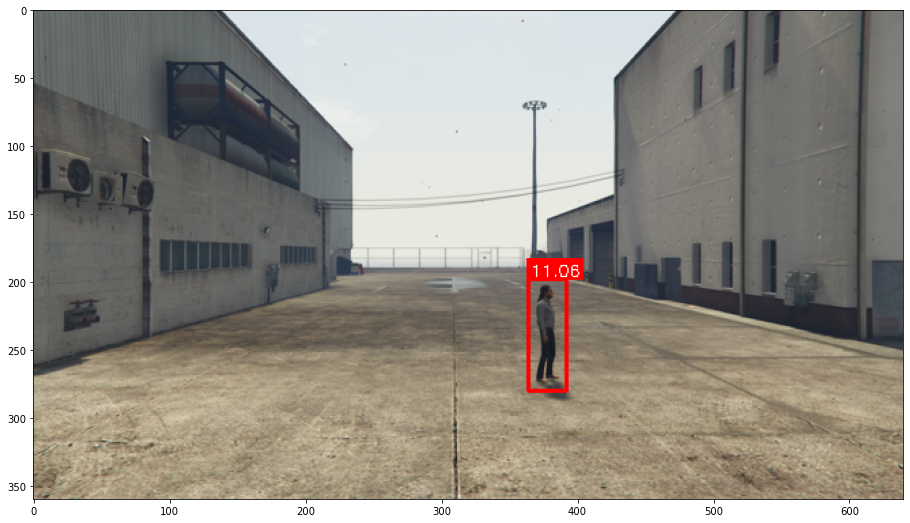

In [41]:
boxes = np.column_stack((person_box, y_pred))

for box in boxes:   
    cv2.rectangle(box_img, (round(box[0]),round(box[1])), (round(box[2]),round(box[3])), (255, 0, 0), 2)
    cv2.rectangle(box_img, (round(box[0]) - 1, round(box[1]) - 15), (round(box[0]) + 40, round(box[1])), (255, 0, 0), -1)
    cv2.putText(box_img, str(round(box[4], 2)), (round(box[0]) + 2, round(box[1]) - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

%matplotlib inline
plt.figure(figsize=(16,9))
plt.imshow(box_img)